## Вариант 1

__Компания по разработке мобильных игр__

### <a id="start">Содержание</a>
   [Задание 1](#task1)<br>
   [Задание 2](#task2)<br>
   [Задание 3](#task3)<br>

In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode
import json

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### <a id="task1"> Задание 1</a>

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

[К содержанию](#start)

In [2]:
# считываю данные

df_reg = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-p-elizarov/shared/problem1-reg_data.csv', sep=';')
df_auth = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-p-elizarov/shared/problem1-auth_data.csv', sep=';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [213]:
# данные о времени регистрации

df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
# данные о времени захода пользователей в игру

df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [5]:
# размеры датафреймов

df_reg.shape

(1000000, 2)

In [6]:
df_auth.shape

(9601013, 2)

In [7]:
# смотрю пропущенные значения

df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [8]:
df_auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [9]:
# уникальные пользователи

df_reg.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [10]:
df_auth.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [11]:
# Типы данных

df_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

In [47]:
df_auth.auth_ts.dtypes

dtype('O')

Все пользователи в данных уникальны, пропущенных значений нет, колонки времени потребуется перевести в тип даты

__Делаю функцию__

In [76]:
def get_retention_rate(df_reg, df_auth, days=7, date_from=None, date_to=None):
    '''
        функция считает retention от даты регистрации
        df_reg - принимает датафрейм с регистрациями,
        df_auth - принимает датафрейм со входами,
        days - период retention в днях,
        date_from - от какой даты считает,
        date_to - до какой даты считает 
        график строится если взяты данные до 70 дней
    ''' 
    
    # приводим timestamp к дате
    if df_reg.reg_ts.dtypes == 'int64' or df_auth.auth_ts.dtypes == 'int64':
        df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'], unit='s').dt.date
        df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts'], unit='s').dt.date
    
    date_from = pd.to_datetime(date_from)
    date_to = pd.to_datetime(date_to)
    
    # фильтр по датам
    if date_from and date_to:
        df_reg = df_reg.query('@date_from <= reg_ts <= @date_to')
    elif date_from:
        df_reg = df_reg.query('@date_from <= reg_ts')
    elif date_to:
        df_reg = df_reg.query('reg_ts <= @date_to')
    
    # объединяю df регистраций и входов
    new_df = df_auth.merge(df_reg, on='uid', how='inner') 
    
    # когорты и уникальные пользователи
    cohort_df = new_df.groupby(['reg_ts', 'auth_ts'], as_index=False).agg(user_count=('uid', 'nunique')) 
    
    # разница в днях между входом и регистрацией
    cohort_df['period_number'] = (cohort_df.auth_ts - cohort_df.reg_ts).dt.days 
    
    # считаем retention
    cohort_df['retention_rate'] = cohort_df['user_count'] / cohort_df.groupby(['reg_ts'])['user_count'].transform('max') 
    
    # переворот таблицы
    cohort_pivot = cohort_df.pivot_table(index='reg_ts', 
                                         columns='period_number', 
                                         values='retention_rate').rename_axis('Day_of_registration') 
    # нужный период
    retention_rate = cohort_pivot.iloc[:, 0:(days + 1)] 
    
    # тоже самое только не в процентах
    count_user = cohort_df[['reg_ts', 'period_number', 'user_count']].rename(columns={'user_count': 'users'})
    user_pivot = count_user.pivot_table(index='reg_ts', 
                                        columns='period_number', 
                                        values='users').rename_axis('Day_of_registration')
    users_rate = user_pivot.iloc[:, 0:(days + 1)] 
    
    # график строится только если меншье двух месяцев
    if retention_rate.shape[0] < 70: 
        ur_style = (users_rate
                    .style
                    .set_caption('User retention by cohort')
                    .highlight_max(axis='index')
                    .highlight_null('white')
                    .format("{:.2f}", na_rep=""))

        plt.figure(figsize=(14, 18))
        sns.heatmap(data=retention_rate,
                    annot=True,
                    fmt='.2%',
                    vmin=0.0,
                    vmax=0.1,
                    cmap='BuGn')

        return ur_style
    else:
        retention_style = (retention_rate
            .style
            .set_caption('User retention by cohort')
            .highlight_max(axis='index')
            .highlight_null('white')
            .format("{:.2%}", na_rep=""))
        return retention_style

period_number,0,1,2,3,4,5,6,7
Day_of_registration,,,,,,,,
2019-01-01,583.00,12.00,22.00,29.00,26.00,37.00,48.00,34.00
2019-01-02,583.00,10.00,29.00,21.00,29.00,47.00,32.00,41.00
2019-01-03,585.00,10.00,18.00,26.00,35.00,37.00,38.00,34.00
2019-01-04,585.00,16.00,22.00,25.00,32.00,32.00,47.00,31.00
2019-01-05,586.00,11.00,24.00,27.00,29.00,48.00,42.00,41.00
2019-01-06,588.00,10.00,22.00,31.00,28.00,35.00,33.00,34.00
2019-01-07,588.00,10.00,25.00,24.00,32.00,43.00,43.00,39.00
2019-01-08,589.00,18.00,24.00,30.00,34.00,42.00,42.00,39.00
2019-01-09,590.00,6.00,16.00,25.00,31.00,35.00,38.00,26.00


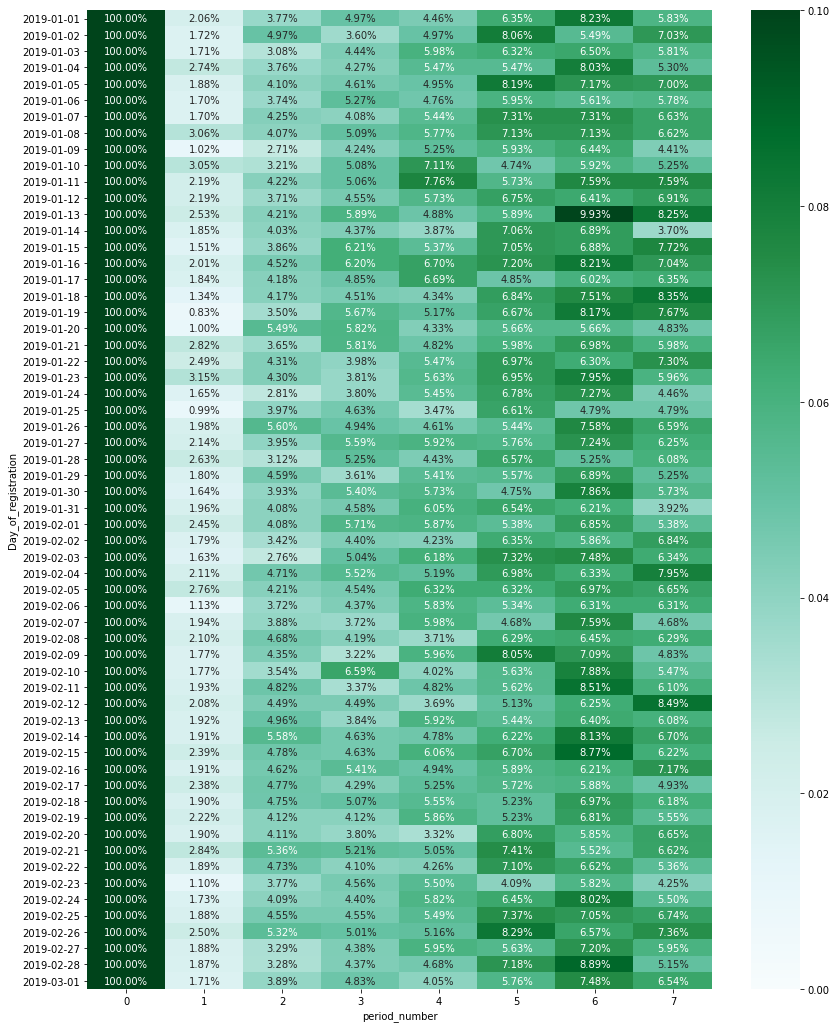

In [78]:
get_retention_rate(df_reg, df_auth, days=7, date_from='2019-01-01', date_to='2019-03-01')

### <a id="task2">Задание 2</a>

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

[К содержанию](#start)

Для принятия решения посмотрю метрики:
* CR - конверсию в покупку
* ARPU - средняя выручка на одного пользователя
* ARPPU - средняя выручка на одного платящего пользователя

In [2]:
# считываю данные

def get_csv_from_yadisk(url):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(final_url)
    parse_href = response.json()['href']
    return parse_href

In [3]:
test = pd.read_csv(get_csv_from_yadisk('https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'), sep=';')

In [51]:
# 404770 пользователей

test

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [5]:
# все пользователи уникальные

test.user_id.nunique()

404770

In [6]:
# отсутствуют пропущенные значения

test.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [7]:
# смотрю типы данных

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [5]:
# в колонке 'revenue' много нулей и выбросы со значением "37433"

test.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

__Все пользователи уникальные и нет пропущенных значений__

In [4]:
# переименовываю группы для удобства

test['testgroup'] = test['testgroup'].apply(lambda x: 'test' if x == 'b' else 'control')

In [5]:
# разделяю группы на 2 датафрейма

control_users = test.query('testgroup == "control"')
test_users = test.query('testgroup == "test"')

In [6]:
# платящие клиенты из разных групп

control_paying_users = test.query('revenue > 0 and testgroup == "control"')
test_paying_users = test.query('revenue > 0 and testgroup == "test"')

In [24]:
# проверим, что ARPU в тестовой группе выше на 5%, чем в контрольной

round(((test_users['revenue'].sum() / len(test_users)) / 
       (control_users['revenue'].sum() / len(control_users)) * 100) - 100, 0)

5.0

ARPU в тестовой группе выше на 5.0 %, чем в контрольной

#### Конверсия в платящих пользователей

In [56]:
# в контрольной группе

cr_control = round(len(control_paying_users) / len(control_users) * 100, 2)
cr_control

0.95

In [57]:
# в тестовой группе

cr_test = round(len(test_paying_users) / len(test_users) * 100, 2)
cr_test

0.89

In [58]:
# конверсия в контрольной группе больше на 6.74%

round((cr_control / cr_test * 100) - 100, 2)

6.74

#### Проверяю статистическую значимость в пропорциях платящие к не платящим пользователям

Для сравнения двух независимых пропорций применяю метод Хи‑Квадрат <br>
и дополнительно точный тест Фишера (т.к. таблица сопряженности 2х2)

__Н0__ - различия в пропорциях нет <br>
__Н1__ - различия в пропорциях имеются

_α = 0.05_

In [59]:
# Создаю таблицу сопряженности

paying_test = len(test_paying_users)
not_paying_test = len(test_users) - len(test_paying_users)
paying_control = len(control_paying_users)
not_paying_control = len(control_users) - len(control_paying_users)

In [60]:
data = {
    'paying': [paying_test, paying_control],
    'not_paying': [not_paying_test, not_paying_control],   
}
contingency = pd.DataFrame(data, index=['test', 'control'])

In [61]:
contingency

,paying,not_paying
test,1805,200862
control,1928,200175


In [62]:
# Хи - квадрат

stat, pval, dof, ex = st.chi2_contingency(contingency)
pval

0.03647561892312602

In [64]:
# точный тест Фишера

stat, pval = st.fisher_exact(contingency)
pval

0.03531815726251507

Оба теста показали __p-value < 0.05__ есть основания принять альтернативную гипотезу <br>
Различия в пропорциях имеются <br>
Получается в контрольной группе статистически значимо больше конверсий в покупку, на 6.74%

#### Какой доход в группах

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

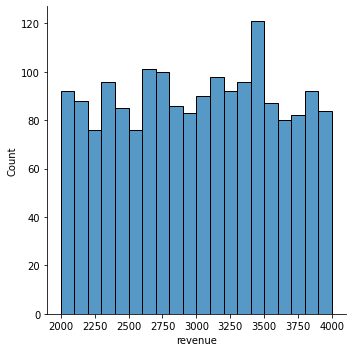

In [8]:
# распределение платящих в тестовой группе

sns.displot(test_paying_users.revenue, bins=20)
test_paying_users.revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

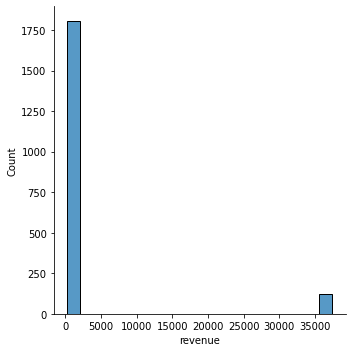

In [66]:
# распределение платящих в контрольной группе

sns.displot(control_paying_users.revenue, bins=20)
control_paying_users.revenue.describe()

In [71]:
control_paying_users.query('revenue > 35000').shape

(123, 3)

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

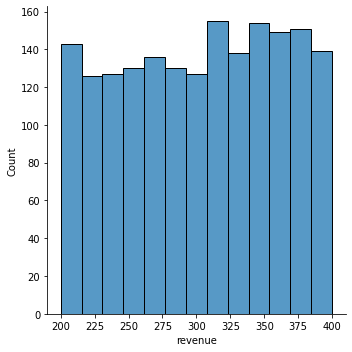

In [72]:
sns.displot(control_paying_users.query('revenue < 5000').revenue)
control_paying_users.query('revenue < 5000').revenue.describe()

В контрольной группе есть пользователи которые сделали покупку стоимостью <br> 
__больше 35000 (123 пользователя)__ буду считать что это выброс. <br>
В контрольной группе revenue распределилось от 200 до 400.

В тестовой группе revenue распределилось от 2000 до 4000

#### Средняя выручка на одного пользователя

__Проверяю являются ли дисперсии внутри групп одинаковыми с помощью критерия Левена__

__Н0__ - дисперсии одинаковые <br>
__Н1__ - дисперсии отличаются

In [8]:
pg.homoscedasticity(data=test, dv='revenue', group='testgroup')

,W,pval,equal_var
levene,0.389629,0.532495,True


p-value > 0.05 дисперсии значимо не отличаются

__Проверяю являются ли распределения нормальными__

__Н0__ - распределения нормальные <br>
__Н1__ - распределения не нормальные

In [22]:
pg.normality(data=test, dv="revenue", group="testgroup", method="normaltest")

,W,pval,normal
test,326622.395409,0.0,False
control,585152.731273,0.0,False


Распределения в обоих группах не нормальные

Дисперсии не отличаются, распределение не нормальное <br>
Выбираю Т-тест так как:
* На больших выборках не сильно нуждается в нормальном распределении
* Дисперсии внутри групп примерно одинаковы


__Т-Тест__

__Н0__ - не имеется различий в средних на одного пользователя между группами <br>
__Н1__ - имеются различия в средних на одного пользователя между группами

In [10]:
pg.ttest(control_users.revenue, test_users.revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


Тест показал __p-value > 0.05__, принимаю нулевую гипотезу <br>
Не имеется различий в средней выручки на одного пользователя между группами

#### Средняя выручка на одного платящего пользователя

__Проверяю являются ли дисперсии внутри групп одинаковыми с помощью критерия Левена__

__Н0__ - дисперсии одинаковые <br>
__Н1__ - дисперсии отличаются

In [19]:
pg.homoscedasticity(data=test.query('revenue != 0'), dv='revenue', group='testgroup')

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


p-value < 0.05 дисперсии значимо отличаются

__Проверяю являются ли распределения нормальными__

__Н0__ - распределения нормальные <br>
__Н1__ - распределения не нормальные

In [20]:
pg.normality(data=test.query('revenue != 0'), dv="revenue", group="testgroup", method="normaltest")

,W,pval,normal
control,1394.945784,1.234161e-303,False
test,1068.860008,7.943249e-233,False


Распределения в обоих группах не нормальные

Дисперсии отличаются, распределение не нормальное <br>
Выбираю Т-тест так как:
* На больших выборках не сильно нуждается в нормальном распределении
* Дисперсии внутри групп не одинаковы, но при примерно одинаковом размере выборок это не критично
  в противном случае можно скорректировать не равные дисперсии с помощью Т-критерий Уэлча
  (в библиотеке pingouin это сделается автоматически)

__Т-Тест__

__Н0__ - не имеется различий в средних на одного платящего пользователя между группами <br>
__Н1__ - имеются различия в средних на одного платящего пользователя между группами

In [21]:
pg.ttest(control_paying_users.revenue, test_paying_users.revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.64463,1943.481522,two-sided,0.100208,"[-744.7, 65.38]",0.052132,0.142,0.356381


Тест показал __p-value > 0.05__, принимаю нулевую гипотезу <br>
Не имеется различий в средней выручке на одного платящего пользователя между группами

Дополнительно проверить bootstrap-ом <br>
__Метод Bootstrap__

In [7]:
# функция для определения разницы средних значений между группами

def my_statistic(sample1, sample2, axis=0):
    mean1 = np.mean(sample1, axis=axis)
    mean2 = np.mean(sample2, axis=axis)
    return mean1 - mean2

In [104]:
# метод bootstrap

ci, bt = pg.compute_bootci(test_paying_users.revenue.values, control_paying_users.revenue.values, 
                           confidence=0.95, func=my_statistic, n_boot=10000, return_dist=True)

In [105]:
# 95% доверительный интервал

ci

array([-19.03, 837.02])

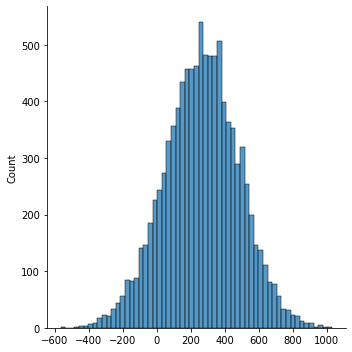

In [106]:
sns.displot(bt, legend=False)

In [113]:
# квантиль в котором расположен ноль

quant = st.norm.cdf(x=0, loc=np.mean(bt), scale=np.std(bt))

In [114]:
p_value = quant * 2 if 0 < np.mean(bt) else (1 - quant) * 2

In [115]:
p_value

0.2264488154650225

Bootstrap брал выборки из двух распределений, считал разницу между средними двух групп  <br>
и из результатов создал новое распределение.

Так как 0 в пределах доверительного интервала, принимаем нулевую гипотезу

#### Вывод

В контрольной группе статистически значимо больше конверсия в покупку на 6.74%.

ARPU и ARPPU статистически не различаются в тестовой и контрольной группах

Набор акционных предложений не повлиял на увеличение дохода от пользователей, но увеличилась конверсия в контрольной группе, я считаю стоит посмотреть на выбросы которые обнаружились, может быть стоит скорректировать сплитование в группы и снова провести эксперимент.

На данный момент акционные предложения в конртольной группе лучше из-за конверсии

### <a id="task3">Задание 3</a>

[К содержанию](#start)

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

__DAU__ - Сколько уникальных пользователей заходит в течении события.

__Retention__ - Если событие идет несколько дней можно посмотреть сколько уникальных игроков заходит в начале события и сколько из них возвращаются в течении события, также посмотреть сколько игроков было на прошлом событии, посмотреть основной ретеншен по игре.

__Average session length__ - Посмотреть на длинну сессии во время события. Можно посчитать среднее по дням и по всему событию, а так же по прохождению уровня.

__Conversion rate__ - Целевое действие закончить событие. Сколько пользователей начали события и сколько закончили, отвалился ли кто-то в процессе на каком-нибудь уровне.

__ARPU__  - увеличился ли доход за время события, может кто-то купит усиления чтобы быстрее или легче пройти событие, а также сравнить с показателями вне события.

__Customer Satisfaction Score__ - можно добавить чтобы пользователи оценивали событие и считать их уровень недовольства.

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

* Можно добавить метрику чтобы смотреть с какой попытки пользователь прошел тот или иной уровень
* Сколько возвращается игроков после провала уровня